In [1]:
# Note: Original saved in Tahir Sproj folder

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
# import pandas as pd

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# File and System Interaction
import os
from pathlib import Path
import torch.optim as optim


# Date and Time Handling
import time
import datetime

# Neural Architecture
try:
    from torchinfo import summary
except:
    # %pip install torchinfo
    from torchinfo import summary
from scipy.fftpack import dct

In [2]:
%load_ext autoreload
%autoreload 2

from python_scripts import dataset_processing
from python_scripts import dustmc_training
from python_scripts import logs_and_results
# from python_scripts import img_pdf_compiler
from python_scripts import utils
from python_scripts import DUST_MC
from python_scripts import dustmc_unrolled
from python_scripts import test
from python_scripts import generate_synthetic_data

In [3]:
# Setting up some global variables

ROOT = os.getcwd().replace('\\', '/') + '/DUSTMC_Data'
# ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
# ROOT = 'C:/Users/HP/GitHub Workspace/ConvHuberMC-Net/HuberMC_Data'
TRY = 'Try 1'
SESSION = 'Session 1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device, ROOT

('cpu', '/home/nehal/GitHubWorkspace/ConvHuberMC-Net/DUSTMC_Data')

In [4]:
# Get parameters --> for convhubermc:
def get_default_param(gpu = True):
    params_net = {}
    params_net['size1'] = 150
    params_net['size2'] = 300
    params_net['rank'] = 10
    
    params_net['device'] = device
        
    params_net['layers'] = 3
    params_net['CalInGPU'] = gpu
    return params_net

In [5]:
hyper_param_net = dustmc_training.get_hyperparameter_grid('DUSTMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, 
                                                          ValBatchSize = 2, num_epochs = 1, learning_rate = 0.001,
                                                          K = 5, mu = 0, sigma = 1, m = 50, n = 150, d = 512, T = 300)
params_net = get_default_param(gpu = True)

In [6]:
train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, ROOT = ROOT)

In [7]:
# Example usage:
model = dustmc_unrolled.DustNet(hyper_param_net)
S = torch.randn(hyper_param_net['n'], hyper_param_net['T'])
output = model(S)
print(output)

tensor([[ -84294.9844,   97864.8047,    3693.7715,  ..., -127126.0938,
         -205962.7500,  241493.4219],
        [ 128747.4297,   -2602.3008,  164356.6562,  ..., -224201.8750,
         -151248.0625,   61215.3516],
        [-352945.8750,   21711.8516,   56746.1172,  ..., -186488.2188,
           99630.6484,   68329.5000],
        ...,
        [ 354256.7500,  -60894.1680, -114337.5938,  ...,  512967.0000,
         -600260.6250,  136868.5156],
        [  49948.0703, -369237.8750,  276503.9688,  ...,  -48941.5312,
          374280.8750,   23832.0234],
        [ 102985.5000, -304237.9688,   39604.4531,  ...,  275858.9062,
           73216.4922,  469192.8125]], grad_fn=<MmBackward0>)


In [8]:
summary(model, input_size = [hyper_param_net['n'], hyper_param_net['T']])

Layer (type:depth-idx)                   Output Shape              Param #
DustNet                                  [150, 300]                84,302
├─ModuleList: 1-1                        --                        --
│    └─BlueBoxLayer: 2-1                 [512, 300]                --
│    │    └─SelfAttention: 3-1           [512, 300]                --
│    │    └─LISTA: 3-2                   [512, 300]                287,745
│    └─BlueBoxLayer: 2-2                 [512, 300]                --
│    │    └─SelfAttention: 3-3           [512, 300]                --
│    │    └─LISTA: 3-4                   [512, 300]                287,745
│    └─BlueBoxLayer: 2-3                 [512, 300]                --
│    │    └─SelfAttention: 3-5           [512, 300]                --
│    │    └─LISTA: 3-6                   [512, 300]                287,745
│    └─BlueBoxLayer: 2-4                 [512, 300]                --
│    │    └─SelfAttention: 3-7           [512, 300]               

Project Name: Try 1 DUSTMC-Net mu 20.0% sigma 3.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'layers': 3, 'CalInGPU': True}

Epoch: 1, 2024-08-09 02:16:54, 

Epoch [1/1], Mean Training Loss:1.55792e+05, Mean Validation Loss:6.20554e+04


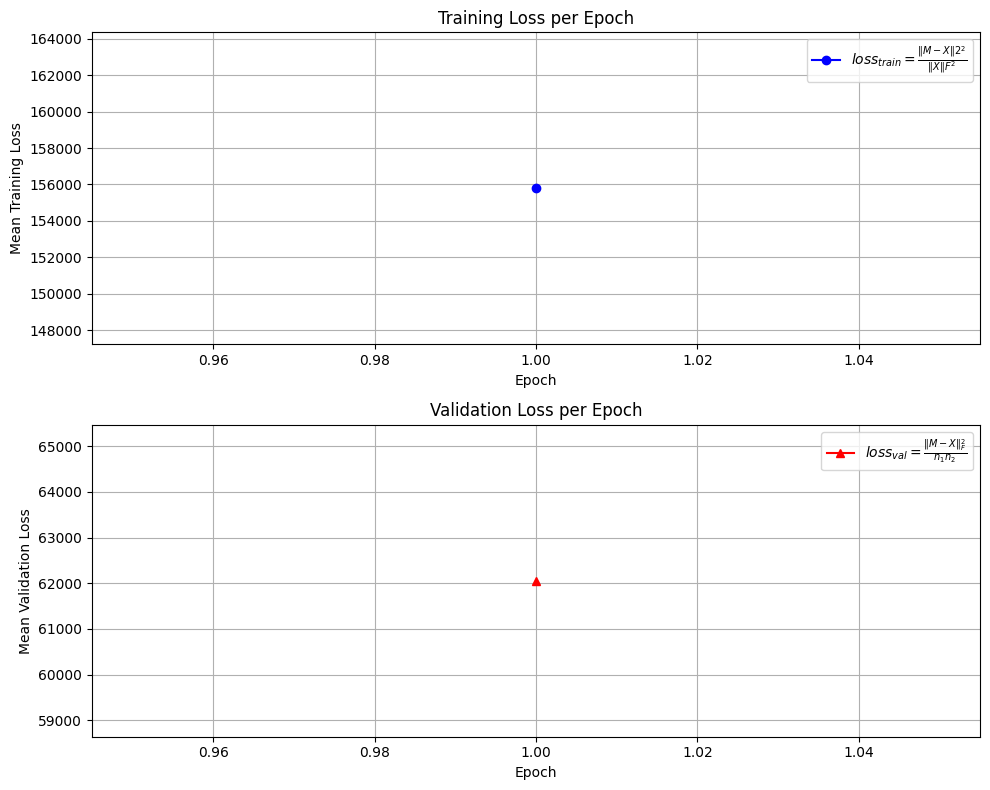

In [9]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data
hyper_param_net = dustmc_training.get_hyperparameter_grid('DUSTMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, 
                                                          ValBatchSize = 2, num_epochs = 1, learning_rate = 0.001,
                                                          K = 5, mu = 0, sigma = 1, m = 50, n = 150, d = 512, T = 300)
params_net = get_default_param(gpu = True)
CalInGPU = params_net['CalInGPU']

mu_list = [0.2]#, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
sigma_list = [3.0]#, 5.0, 6.0, 9.0]

for mu in mu_list:
    for sigma in sigma_list:
        # ProjectName = TRY + ' ' + logs_and_results.get_current_time() + ' ' + hyper_param_net['Model'] + ' ' + 'Sampling Rate: ' + logs_and_results.get_q_str(q) + ' and DB ' + logs_and_results.get_noise_str(db)

        ProjectName = TRY + ' ' + hyper_param_net['Model'] + ' mu ' + logs_and_results.get_q_str(mu) + ' sigma ' + logs_and_results.get_noise_str(sigma)
        # Note: Removed time stamp from log file name as : not supported. Weird because this was not a problem in linux

        # Get log file
        logfile = logs_and_results.get_modularized_record(ProjectName, mu, sigma, 'Logs', hyper_param_net, params_net, ROOT, SESSION)
        with open(logfile, 'w', 1) as log:
            print('Project Name: %s\n'%ProjectName)
            log.write('Project Name: %s\n\n'%ProjectName)

            # Get Model
            net = dustmc_training.get_model(params_net, hyper_param_net, log)
            print('\nParameters = \n%s\n'%str(params_net))
            log.write('\nParameters = \n%s\n\n'%str(params_net))

            #Loading data and creating dataloader for both test and training
            # print('Loading Data phase...')
            log.write('Loading phase...\n')
            shape_dset = (params_net['size1'], params_net['size2'])
            
            train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, ROOT = ROOT)

            # print('Finished loading.\n')
            log.write('Finished loading.\n\n')

            # Some additional settings for training including loss, optimizer,
            # floss = nn.functional.mse_loss(reduction = 'sum')
            floss = nn.MSELoss()
            optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
            # scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma = 0.97, verbose = True)

            # Array for recording parameter values after each layer for each epoch etc
            outputs_L = dustmc_unrolled.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU) 
            lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
            lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))


            # dummy variable to monitor and record progress for loss
            minloss = np.inf

            for epoch in range(hyper_param_net['Epochs']):
                print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
                log.write(f'Epoch: {epoch + 1} ')
                log.write(logs_and_results.get_current_time() + '\n\n')

                # Train and Test Steps. (Record every 5 epochs)
                if (epoch + 1) % 5 == 0:
                    # print('Loading and calculating training batches...')
                    log.write('Loading and calculating training batches...\n')
                    startime = time.time()
                    loss_mean = dustmc_training.train_step(net, train_loader, floss, optimizer, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize']) # remove alpha from train func
                    endtime = time.time()
                    # print('Training time is %f'%(endtime - startime))
                    log.write('Training time is %f'%(endtime - startime))

                    # print('Loading and calculating validation batches...')
                    log.write('Loading and calculating validation batches...\n')
                    startime = time.time()
                    loss_val_mean = dustmc_training.test_step(net, val_loader, floss, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
                    endtime = time.time()
                    # print('Test time is %f'%(endtime - startime))
                    log.write('Test time is %f'%(endtime - startime))

                else:
                    loss_mean = dustmc_training.train_step(net, train_loader, floss, optimizer, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
                    loss_val_mean = dustmc_training.test_step(net, val_loader, floss, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

                # Update Record and Parameters
                lossmean_vec[epoch] = loss_mean
                lossmean_val_vec[epoch] = loss_val_mean


                print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                      %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))

                # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
                if (epoch + 1) % 5 == 0:
                    print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_whole_path = logs_and_results.get_modularized_record(ProjectName, mu, sigma, 'Saved Models - Whole', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net, model_whole_path)
                    print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, mu, sigma, 'Saved Models - Dict', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net.state_dict(), model_state_dict_path)

                    log.write('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e\n'
                              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    np.set_printoptions(precision = 3)

                    if True or loss_val_mean < minloss:
                        # print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
                        log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
                        minloss = min(loss_val_mean, minloss)

            # Finish off by observing the minimum loss on validation set

            #Print min loss
            # print('\nMin Loss = %.4e'%np.min(lossmean_val_vec))
            log.write('\nMin Loss = %.4e'%np.min(lossmean_val_vec))

            # Plotting MSE vs Epoch and Saving it

            # Get Directory where we have to save the plot
            dir = logs_and_results.get_modularized_record(ProjectName, mu, sigma, 'Plots', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
            logs_and_results.plot_and_save_mse_vs_epoch(lossmean_vec, lossmean_val_vec, dir)

In [10]:
import torch

# Example values
DH = torch.randn(10, 5)  # Shape (n, T)

# Compute βi values
beta_i = torch.exp(-0.5 * torch.sum(DH ** 2, dim=0))  # Shape (T,)

# Ensure indexing returns a tensor
index = 2
indexed_value = beta_i[index]

print(f"beta_i: {beta_i}")
print(f"Indexed value: {indexed_value}")
print(f"Type of indexed value: {type(indexed_value)}")  # Should be <class 'torch.Tensor'>


beta_i: tensor([0.0221, 0.0345, 0.0003, 0.0150, 0.0002])
Indexed value: 0.0003437580307945609
Type of indexed value: <class 'torch.Tensor'>


In [11]:
# Get relevant arguements for DUSTMC

M_train, M_Omega_train, M_test, M_Omega_test = generate_synthetic_data.generate_simple_gaussian_noise(150, 300, 10, 10, 2, 0.5, 3)

In [12]:
# Set the random seed for reproducibility
# np.random.seed(42)

rand_batch_idx = np.random.randint(0, M_Omega_train.shape[0])
X = M_Omega_train[rand_batch_idx, :, :]

# Initialize a m x n A measurement sensing matrix with random values from a uniform distribution between 0 and 1
A = np.random.uniform(0, 1, (100, 150)) # A is m x n. Since m << n and n is normally 150

# Initalize the Dictonary D which is n x d and d >> n by DCT. d is taken as 512
random_matrix = np.random.uniform(0, 1, (150, 512))

# Apply the Discrete Cosine Transform (DCT) to the matrix
D = dct(random_matrix, type = 2, norm = 'ortho')

# Initialize K (no. of iterations), and hyperparameters lambda_1, lambda_2, and c
K = 50
lambda_1 = 0.1
lambda_2 = 0.4
c = 1

In [13]:
# Now run the attention based algo on X to get its recovered/reconstructed form S
S = test.attention_based_algo(A, D, X, K, lambda_1, lambda_2, c)

/home/nehal/GitHubWorkspace/ConvHuberMC-Net/python_scripts/test.py:49: RuntimeWarning: overflow encountered in exp
  exp_values = np.exp(exponent_terms)
/home/nehal/GitHubWorkspace/ConvHuberMC-Net/python_scripts/test.py:52: RuntimeWarning: invalid value encountered in multiply
  G_numerator = np.sum(beta_values[:, None] * exp_values[:, None] * H.T, axis=0)
/home/nehal/GitHubWorkspace/ConvHuberMC-Net/python_scripts/test.py:53: RuntimeWarning: invalid value encountered in multiply
  G_denominator = np.sum(beta_values * exp_values)


In [14]:
# Now measure loss between reconstructed and groundtruth

groundtruth = M_train[rand_batch_idx, :, :]

print(f'The squared L2 norm loss is: {utils.compute_squared_l2_norm_loss(S, groundtruth)}')

The squared L2 norm loss is: nan
